In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import random
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

import seaborn as sns
from matplotlib import pyplot

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

nltk.download("stopwords", quiet=True)

True

In [2]:
corpus = pd.read_csv('corpus.csv')
corpus = corpus.drop_duplicates()
corpus.shape

(4911, 2)

In [3]:
def custom_sentence_splitter(row):
    '''
    method to convert rows into sentences, custom cleaning has been performed
    '''
    pattern = r'(?:[A-Za-z]\.)+'
    sentences = []
    sen = ''
    for w in row.split(" "):
        if w.endswith("."):
            if len(re.findall(r'(?:[A-Za-z]\.)', w)) > 1: 
                # ignoring handling acronym
                pass          
            elif len(re.findall(r'(?:[0-9]\.)', w)) == 1:
                # ignoring numbers
                pass
            else:
                sen += " " + w
                sen = sen.strip(".").strip(" ")
                if len(sen):
                    sentences.append(sen)
                sen = w = ""
        elif "." in w:
            pattern = r'(?:([A-Za-z0-9()\.]{1,})\.([A-Za-z]{2,}))'
            if len(re.findall(pattern=pattern, string=w)):
                sp = w.split(".")
                sen += " " + ".".join(sp[:-1])
                sen = sen.strip(".").strip(" ")
                if len(sen): sentences.append(sen)
                sen = ""
                w = sp[-1]
        sen += " " + w
      
    sen = sen.strip(".").strip(" ")
    if len(sen):
        sentences.append(sen.strip(".").strip(" "))
    return sentences


#### Converting rows to sentences

In [4]:

pos_tagged_sentences = []
for i, row in tqdm(corpus.iterrows()):
    for i, sen in enumerate(custom_sentence_splitter(row['Section_Text'])):
        pos_tagged_sentences.append({
            "Section_ID": row["Section_ID"],
            "Sentence_ID": "{}_{}".format(row["Section_ID"], i),
            "Sentence": sen, 
        })

print(len(pos_tagged_sentences))

4911it [00:02, 2092.27it/s]

19254


In [5]:
df_ = pd.DataFrame.from_records(pos_tagged_sentences)
df_.shape

(19254, 3)

In [6]:
df_.head()

,Section_ID,Sentence,Sentence_ID
0,Cite-1,authority,Cite-1_0
1,Cite-1,"this part is issued pursuant to 12 u.s.c. 1, 1...",Cite-1_1
2,Cite-2,purpose this part prescribes standards under w...,Cite-2_0
3,Cite-3,scope,Cite-3_0
4,Cite-3,the standards set forth in this part apply to ...,Cite-3_1


#### Cleaning Sentences, Removing special characters and Stop Words 

In [7]:
REMOVE_STOPWORDS = True
stops = set(stopwords.words("english"))

def clean_text(text):
    text =  re.sub(r"[^A-Za-z0-9.]", " ", text)    
    
    if REMOVE_STOPWORDS:
        words = [w.strip(" ").strip(".") for w in text.lower().split(" ") if not w in stops]
        return " ".join(words)
    else:
        return text


In [8]:
index = 1000
print(df_.Sentence.iloc[index])
print("\n")
print(clean_text(df_.Sentence.iloc[index]))

electronic media includes any means for transmitting messages electronically between a covered person and a consumer in a format that allows visual text to be displayed on equipment, for example, a personal computer monitor


electronic media includes means transmitting messages electronically covered person consumer format allows visual text displayed equipment  example  personal computer monitor


In [9]:
df_['clean_sentence'] = df_.Sentence.apply(clean_text)
df_.head()    

,Section_ID,Sentence,Sentence_ID,clean_sentence
0,Cite-1,authority,Cite-1_0,authority
1,Cite-1,"this part is issued pursuant to 12 u.s.c. 1, 1...",Cite-1_1,part issued pursuant 12 u.s.c 1 12 u.s.c 24 ...
2,Cite-2,purpose this part prescribes standards under w...,Cite-2_0,purpose part prescribes standards national ban...
3,Cite-3,scope,Cite-3_0,scope
4,Cite-3,the standards set forth in this part apply to ...,Cite-3_1,standards set forth part apply national banks ...


#### Building Doc2Vec Model

In [10]:
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(df_.clean_sentence)]

In [11]:
documents[1000]

TaggedDocument(words=['electronic', 'media', 'includes', 'means', 'transmitting', 'messages', 'electronically', 'covered', 'person', 'consumer', 'format', 'allows', 'visual', 'text', 'displayed', 'equipment', 'example', 'personal', 'computer', 'monitor'], tags=[1000])

In [12]:
model = Doc2Vec(min_count=1, window=5, vector_size=150, epochs=50, workers=16)
model.build_vocab(documents)

In [13]:
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [14]:
model.wv.most_similar("law")

[('statute', 0.6516011953353882),
 ('laws', 0.537441611289978),
 ('expedient', 0.5153548717498779),
 ('inspected', 0.5084964036941528),
 ('authorities', 0.48979926109313965),
 ('adjudications', 0.4893532395362854),
 ('unexcused', 0.47509637475013733),
 ('inrepresentational', 0.4582762122154236),
 ('constitution', 0.45680633187294006),
 ('stayed', 0.4521963894367218)]

In [15]:
model.wv.n_similarity(df_.clean_sentence[100].split(), df_.clean_sentence[200].split())

0.07586824

#### Plotting similarities between random 25 senences

In [16]:
sample = df_.clean_sentence.sample(25).reset_index(drop=True)

In [17]:
similarity_scores = np.zeros((25,25))
for i, sen1 in enumerate(sample):
    for j, sen2 in enumerate(sample): 
        sim = model.wv.n_similarity(sen1.split(), sen2.split())    
        similarity_scores[i][j] = sim

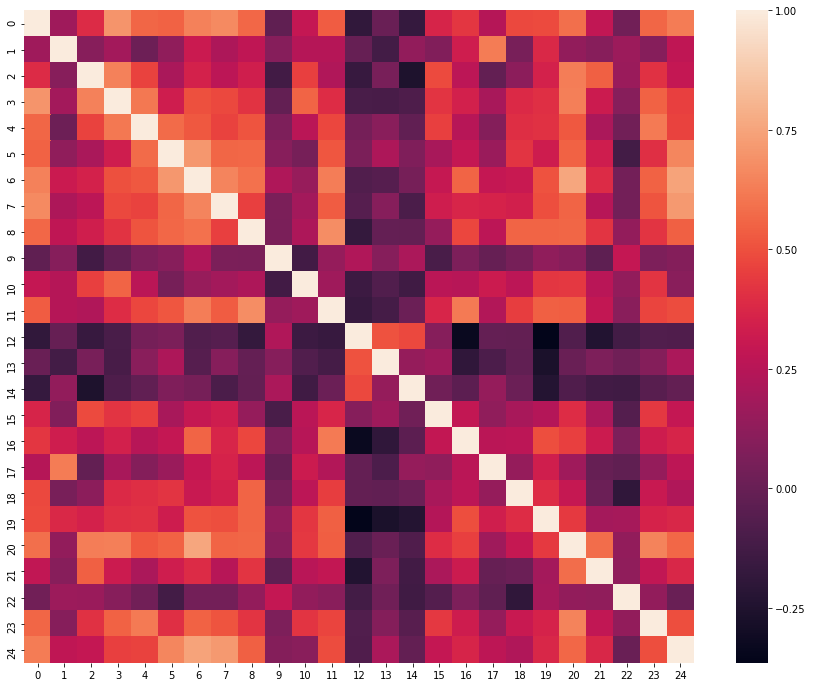

In [18]:
fig, ax = pyplot.subplots(figsize=(15,12))
sns.heatmap(ax=ax, data=similarity_scores)